# 🔍 Wind Turbine Defect Detection with Faster R-CNN  
**State-of-the-art object detection for identifying blade defects from drone imagery using a pretrained Faster R-CNN model.**  

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import json
import matplotlib.pyplot as plt
import warnings
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import matplotlib.patches as patches
import torch.nn.functional as F


warnings.filterwarnings('ignore')
%matplotlib inline

torch.backends.cudnn.benchmark = True
torch.manual_seed(17)
torch.cuda.manual_seed(17)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


# 0. Create dataset class and instantiate dataset and dataloader.

In [2]:
class DTUDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            annotation_file (str): Path to the annotation file in COCO format (e.g., from GitHub).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = self.load_annotations(annotation_file)

    def load_annotations(self, annotation_file):
        with open(annotation_file, 'r') as f:
            return json.load(f)

    def slice_image(self, image_path, tile_size=1024):
        try:
            row, col = map(int, image_path.split('/')[-1].split('.')[0].split('_')[-2:])
            new_path = image_path.split('.')[0][:-4] + '.JPG'
            image = Image.open(new_path).convert('RGB')
            width, height = image.size

            left = col * tile_size
            upper = row * tile_size
            right = left + tile_size
            lower = upper + tile_size

            if right > width or lower > height:
                raise ValueError(f"Slice ({row}, {col}) exceeds image bounds: {width}x{height}")

            return image.crop((left, upper, right, lower))

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        img_info = self.annotations['images'][idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        slc = self.slice_image(img_path)

        if self.transform:
            image = self.transform(slc)

        ann_ids = [ann for ann in self.annotations['annotations'] if ann['image_id'] == img_info['id']]
        boxes = [ann['bbox'] for ann in ann_ids]
        labels = [ann['category_id'] for ann in ann_ids]

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
        }

        return image, target


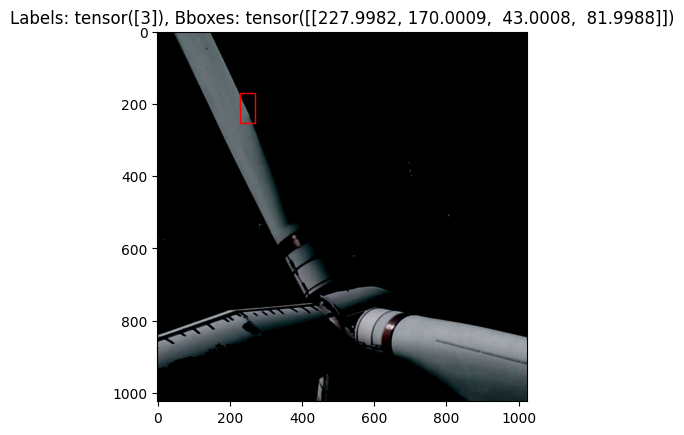

In [3]:
annotations_dir = "DTU-annotations-main/"
dataset_zip = "DTU - Drone inspection images of wind turbine/"

if not os.path.exists(annotations_dir):
    os.system('wget https://github.com/imadgohar/DTU-annotations/archive/refs/heads/main.zip')
    os.system('unzip -o main.zip')
    os.system('rm main.zip')

if not os.path.exists(dataset_zip):
    os.system('wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hd96prn3nc-2.zip')
    os.system('unzip -o hd96prn3nc-2.zip')
    os.system('rm hd96prn3nc-2.zip')

os.system('mv "DTU - Drone inspection images of wind turbine/DTU - Drone inspection images of wind turbine/Nordtank 2017"/*.JPG "DTU - Drone inspection images of wind turbine/DTU - Drone inspection images of wind turbine/"')
os.system('mv "DTU - Drone inspection images of wind turbine/DTU - Drone inspection images of wind turbine/Nordtank 2018"/*.JPG "DTU - Drone inspection images of wind turbine/DTU - Drone inspection images of wind turbine/"')

root_dir = "DTU - Drone inspection images of wind turbine/DTU - Drone inspection images of wind turbine/"
annotation_file = "DTU-annotations-main/re-annotation/D3/train.json"

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5)),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = DTUDataset(root_dir=root_dir, annotation_file=annotation_file, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

data_iter = iter(train_dataloader)
images, targets = next(data_iter)

image = images[0]
target = targets[0]
array = image.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

fig, ax = plt.subplots(1)
ax.imshow(array)

for box in target['boxes']:
    x_min, y_min, width, height = box
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Plot the image
plt.imshow(array)
plt.title(f"Labels: {target['labels']}, Bboxes: {target['boxes']}")
plt.show()




# 1. Define the Mask R-DSCNN model.

In [4]:
backbone = resnet_fpn_backbone('resnet50', pretrained=True)

anchor_generator = AnchorGenerator(
sizes=((32,), (64,), (128,), (256,), (512,)),
aspect_ratios=((0.5, 1.0, 2.0),) * 5)

num_classes = 6

model = FasterRCNN(
    backbone=backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]



# 2. Train the model.

In [5]:
def train_model(model, optimizer, dataloader, num_epochs=20, device='cuda'):
    """
    Train the Mask R-CNN model with a specified dataloader and optimizer.

    Args:
        model (nn.Module): The Mask R-CNN model.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        dataloader (torch.utils.data.DataLoader): Dataloader for the training data.
        num_epochs (int): Number of training epochs.
        device (str): Device to use for training (e.g., 'cuda' or 'cpu').

    Returns:
        None
    """
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for images, targets in dataloader:
            for target in targets:
                array = target['boxes'].numpy()
                x_min, y_min, width, height = array[0]
                x_max = x_min + width
                y_max = y_min + height
                target['boxes'] = torch.tensor([[
                    x_min, y_min, x_max, y_max
                ]], dtype=torch.float32)

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            try:
                loss_dict = model(images, targets)

                loss = sum(loss for loss in loss_dict.values())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                loss_logs = " | ".join([f"{k}: {v.item():.4f}" for k, v in loss_dict.items()])
                print(f"Batch Loss: {loss.item():.4f} | {loss_logs}")

            except AssertionError as e:
                print(f"Skipping batch due to error: {e}")
                continue

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Total Loss: {epoch_loss:.4f}")

def evaluation(model, dataloader, device='cuda'):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)

            for i, prediction in enumerate(predictions):
                print(f"Image {i}:")
                print(f"  Boxes: {prediction['boxes']}")
                print(f"  Labels: {prediction['labels']}")
                print(f"  Scores: {prediction['scores']}")

                # Calculate loss
                loss = criterion(prediction['scores'], targets[i]['labels'])
                total_loss += loss.item()

                # Calculate accuracy
                _, predicted_labels = torch.max(prediction['scores'], 1)
                total_correct += (predicted_labels == targets[i]['labels']).sum().item()
                total_samples += targets[i]['labels'].size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples * 100

    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")

In [ ]:

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

model_path = "./mask_rcnn_dtu.pth"

if not os.path.exists(model_path):
    train_model(model, optimizer, train_dataloader, num_epochs=20, device=device)

    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

else:
    if not torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    else:
        model.load_state_dict(torch.load(model_path))

    model.to(device)
    print(f"Model loaded from {model_path}")



Epoch 1/20
Batch Loss: 2.2431 | loss_classifier: 1.4682 | loss_box_reg: 0.0006 | loss_objectness: 0.6850 | loss_rpn_box_reg: 0.0893
Batch Loss: 1.9702 | loss_classifier: 1.2727 | loss_box_reg: 0.0114 | loss_objectness: 0.6705 | loss_rpn_box_reg: 0.0156
Batch Loss: 1.1265 | loss_classifier: 0.4889 | loss_box_reg: 0.0024 | loss_objectness: 0.5773 | loss_rpn_box_reg: 0.0580
Batch Loss: 1.0124 | loss_classifier: 0.4907 | loss_box_reg: 0.0120 | loss_objectness: 0.4679 | loss_rpn_box_reg: 0.0418
Batch Loss: 0.3849 | loss_classifier: 0.0911 | loss_box_reg: 0.0065 | loss_objectness: 0.2384 | loss_rpn_box_reg: 0.0489
Batch Loss: 0.7076 | loss_classifier: 0.1224 | loss_box_reg: 0.0105 | loss_objectness: 0.2878 | loss_rpn_box_reg: 0.2870
Batch Loss: 0.8679 | loss_classifier: 0.2657 | loss_box_reg: 0.0327 | loss_objectness: 0.4099 | loss_rpn_box_reg: 0.1595
Batch Loss: 0.7164 | loss_classifier: 0.5243 | loss_box_reg: 0.0687 | loss_objectness: 0.1021 | loss_rpn_box_reg: 0.0214
Batch Loss: 0.3130 |

In [ ]:
annotation_file = "DTU-annotations-main/re-annotation/D3/test.json"

test_dataset = DTUDataset(root_dir=root_dir, annotation_file=annotation_file, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

evaluation(model, test_dataloader, device=device)


In [ ]:
annotation_file = "DTU-annotations-main/re-annotation/D3/test.json"
eval_dataset = DTUDataset(root_dir=root_dir, annotation_file=annotation_file, transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

eval_iter = iter(eval_dataloader)
eval_image, eval_target = next(eval_iter)

eval_image = [img.to(device) for img in eval_image]

model.eval()
with torch.no_grad():
    prediction = model(eval_image)

eval_image_np = eval_image[0].permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1)
ax.imshow(eval_image_np)

for box, label in zip(prediction[0]['boxes'], prediction[0]['labels']):
    x_min, y_min, x_max, y_max = box.cpu().numpy()
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, str(label.item()), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

for box, label in zip(eval_target[0]['boxes'], eval_target[0]['labels']):
    x_min, y_min, width, height = box.cpu().numpy()
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, str(label.item()), color='white', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))

plt.title("Predicted and Annotated Bounding Boxes and Labels")
plt.show()

# Custom Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone



def get_max_prob_bbox(batch_output):
    """
    Extracts the bounding box with the highest probability for each image in the batch, including logits.

    Args:
        batch_output (torch.Tensor): Output of the model of shape (B, 11, 16, 16).

    Returns:
        List of bounding boxes and logits for each image in the batch.
    """
    batch_size, _, grid_h, grid_w = batch_output.shape
    num_classes = batch_output.size(1) - 5  # Exclude bbox and confidence values

    # Split output into bbox, confidence, and class probabilities
    bbox_preds = batch_output[:, :5, :, :]  # (B, 5, 16, 16)
    class_logits = batch_output[:, 5:, :, :]  # (B, num_classes, 16, 16)

    # Calculate final confidence scores (using logits directly)
    conf_scores = bbox_preds[:, 4, :, :] * F.softmax(class_logits, dim=1).max(dim=1).values  # (B, 16, 16)

    results = []
    for i in range(batch_size):
        # Find grid cell with max confidence
        max_conf_idx = torch.argmax(conf_scores[i])  # Flattened index
        grid_y, grid_x = divmod(max_conf_idx.item(), grid_w)

        # Extract bounding box and logits
        x, y, w, h, _ = bbox_preds[i, :, grid_y, grid_x]
        logits = class_logits[i, :, grid_y, grid_x]  # Logits for all classes at this cell

        # Adjust bbox to image scale
        x_center = (grid_x + x.item()) / grid_w
        y_center = (grid_y + y.item()) / grid_h
        width = w.item() / grid_w
        height = h.item() / grid_h

        results.append({
            "bbox": torch.tensor([x_center, y_center, width, height]),
            "logits": logits  # Return logits instead of label
        })

    return results

class TinyYOLOv2(nn.Module):
    def __init__(self, num_classes):
        super(TinyYOLOv2, self).__init__()

        self.backbone = resnet_fpn_backbone('resnet18', pretrained=True)

        # Feature map processing layers
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool6 = nn.MaxPool2d(2, 2, ceil_mode=True)

        self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(1024)

        self.conv8 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(1024)

        # Detection layer
        self.detector = nn.Conv2d(1024, num_classes + 5, kernel_size=1)

    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone(x)['0']  # Using the first level of FPN as feature input

        # Pass features through TinyYOLOv2 processing layers
        x = self.pool6(F.leaky_relu(self.bn6(self.conv6(features)), negative_slope=0.1))
        x = F.leaky_relu(self.bn7(self.conv7(x)), negative_slope=0.1)
        x = F.leaky_relu(self.bn8(self.conv8(x)), negative_slope=0.1)
        x = self.detector(x)

        return get_max_prob_bbox(x)


In [ ]:
# Pipeline for custom Yolo v2-tiny Network
from tqdm.notebook import trange, tqdm

def train_model(model, optimizer, dataloader, cls_loss_fn, reg_loss_fn, num_epochs=200):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data_inputs, data_labels in dataloader:

            ## Step 0 (needed in case of GPU): Move input data to device
            data_inputs = torch.stack(data_inputs).to(device)
            # data_labels = data_labels.to(device)

            # Step 1: setting gradients to zero. The gradients would not be overwritten but actually added to the existing ones.
            optimizer.zero_grad()

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            preds_bboxes = torch.stack([p['bbox'] for p in preds]).to(device)
            preds_logits = torch.stack([p['logits'] for p in preds]).to(device)

            ann_bboxes = torch.stack([p['boxes'][0] for p in data_labels]).to(device)
            ann_labels = torch.stack([p['labels'][0] for p in data_labels]).to(device)

            classification_loss = cls_loss_fn(preds_logits, ann_labels)
            regression_loss = reg_loss_fn(preds_bboxes, ann_bboxes)

            loss = classification_loss + regression_loss

            ## Step 4: Perform backpropagation
            loss.backward()

            ## Step 5: Update parameters based on the calculated gradients
            optimizer.step()

            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()

        # Add average loss to TensorBoard
        epoch_loss /= len(dataloader)
        print('[%d] loss: %.3f' % (epoch + 1, epoch_loss))

def eval_model(model, data_loader):
    # Set model to eval mode
    model.eval()

    true_preds, num_preds = 0., 0.

    # Deactivate gradients for the following code
    with torch.no_grad():

        # get batch of images from the test DataLoader
        for data_inputs, data_labels in data_loader:
            ## Step 0 (needed in case of GPU): Move input data to device
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            # Step 1: determine prediction of model
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]
            #preds = torch.sigmoid(preds)  # UNCOMMNET if nn.BCEWithLogitsLoss is selected.  Sigmoid to map predictions between 0 and 1. Be aware that the l

            # Step 2: Binarize predictions to 0 and 1
            pred_labels = (preds >= 0.5).long()

            # Step 3: Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")


In [ ]:
model = TinyYOLOv2(num_classes=6)
model.to(device)

cls_loss_fn = nn.CrossEntropyLoss().to(device)
reg_loss_fn = nn.SmoothL1Loss().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

train_model(model, optimizer, train_dataloader, cls_loss_fn, reg_loss_fn, num_epochs=50)